In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#install weights and biases for data logging
# 26fd22ecbe5d0d2e53f656dbee7cedad16503a06
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 72.3 MB/s 
     |████████████████████████████████| 168 kB 57.8 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 77.2 MB/s 
     |████████████████████████████████| 166 kB 76.6 MB/s 
     |████████████████████████████████| 166 kB 80.4 MB/s 
     |████████████████████████████████| 162 kB 69.0 MB/s 
     |████████████████████████████████| 162 kB 76.9 MB/s 
     |████████████████████████████████| 158 kB 85.8 MB/s 
     |████████████████████████████████| 157 kB 83.6 MB/s 
     |████████████████████████████████| 157 kB 72.2 MB/s 
     |████████████████████████████████| 157 kB 78.3 MB/s 
     |████████████████████████████████| 157 kB 76.4 MB/s 
     |████████████████████████████████| 157 kB 82.5 MB/s 
     |███████████████████████████

In [ ]:
#time all processes to measure network efficiency
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.1 MB/s 
time: 472 µs (started: 2022-12-09 20:27:24 +00:00)


**Imports**

In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations
import wandb
from numpy import random
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter

time: 7.09 s (started: 2022-12-09 20:27:24 +00:00)


In [ ]:
#unzip 10k train data
!unzip '/content/gdrive/MyDrive/mobilenet/dataset_10000.zip' -d './'

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset_100000/008334_seg.png  
  inflating: ./dataset_100000/008335.png  
  inflating: ./dataset_100000/008335_ldmks.txt  
  inflating: ./dataset_100000/008335_seg.png  
  inflating: ./dataset_100000/008336.png  
  inflating: ./dataset_100000/008336_ldmks.txt  
  inflating: ./dataset_100000/008336_seg.png  
  inflating: ./dataset_100000/008337.png  
  inflating: ./dataset_100000/008337_ldmks.txt  
  inflating: ./dataset_100000/008337_seg.png  
  inflating: ./dataset_100000/008338.png  
  inflating: ./dataset_100000/008338_ldmks.txt  
  inflating: ./dataset_100000/008338_seg.png  
  inflating: ./dataset_100000/008339.png  
  inflating: ./dataset_100000/008339_ldmks.txt  
  inflating: ./dataset_100000/008339_seg.png  
  inflating: ./dataset_100000/008340.png  
  inflating: ./dataset_100000/008340_ldmks.txt  
  inflating: ./dataset_100000/008340_seg.png  
  inflating: ./dataset_100000/008341.png  
  inflating: ./dataset_10

**Config**

In [ ]:
#paths
TEST_ROOT_PATH = '/content/gdrive/MyDrive/300W'
TRAIN_ROOT_PATH = '/content/dataset_100000'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

#set to True if you want to augment traning data
#Augmentations = {Random Mask, Random Rotation}
DATA_AUGMENTATION = False

time: 647 ms (started: 2022-12-09 20:28:37 +00:00)


###Augmentation

In [ ]:
class Config():
    def __init__(self):
        self.input_size = 244
        self.experiment_name = None

cfg = Config()
cfg.experiment_name = "01"

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image


def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

time: 136 ms (started: 2022-12-09 20:28:38 +00:00)


**Utility**

In [ ]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.astype(np.uint8))
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.astype(np.uint8))
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img,(1,2,0))
        print('visualize img.shape',img.shape)
        #cv2.imwrite('/content/gdrive/MyDrive/mobilenet/img_'+str(i)+'.jpg',img)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    #cv2_imshow(img)
    plt.show()
    plt.close()


# def show_points_validation(data):
#   plt.figure(figsize=(10, 10))
#   for i in range(9):
#         sample = data[i]

#         image = sample['image']
#         image = image.numpy()
#         image = np.transpose(image,(1,2,0))
#         plt.subplot(3, 3, i+1)

    
#         keypoints = sample['keypoints']
#         keypoints = keypoints.reshape(70,2)
  
#         plt.imshow(image)
#         for j in range(len(keypoints)):
#             plt.plot(keypoints[j,0]*224,keypoints[j,1]*224, 'bo', markersize = 1)
        
#         plt.show()
#         plt.close()  

#   return

time: 3.46 ms (started: 2022-12-09 20:28:38 +00:00)


**Dataset Class**

In [ ]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_keypoints(file_name):
  #remove file extension from file_name
  idx = [idx for idx, x in enumerate(file_name) if x == '.']
  file_name = file_name[:idx[0]]
  #get name of keypoint file
  file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
  #fetch file and extract keypoints as list of tuples
  keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
  keypoints = np.array(keypoints, dtype='float32')
  return keypoints

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([transforms.RandomGrayscale(0.2),
                                             transforms.Resize(cfg.input_size),
                                             transforms.ToTensor(),
                                             normalize])

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints

    def __getitem__(self, index):
        image = Image.open(f"{self.path}/{self.data[index]}").convert('RGB')
        orig_w, orig_h = image.size
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        #do keypoint preprocessing:
        keypoints = keypoints/512
        keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
        keypoints = keypoints[:,0]
        # apply data augmentation
        #rotate image
        image, keypoints = random_rotate(image, keypoints, 30, True)
        keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
        #translate image
        image, keypoints = random_translate(image, keypoints, True)
        keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
        #add occlusion
        image = random_occlusion(image, True)
        #add blur
        image = random_blur(image, True)
        image = self.transform(image)
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [cfg.input_size, cfg.input_size]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500]) 
      return data

time: 9.97 ms (started: 2022-12-09 20:28:38 +00:00)


**Setup Data**

Training sample instances: 9001
Validation sample instances: 1000


visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)


visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)


visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)
visualize img.shape (244, 244, 3)


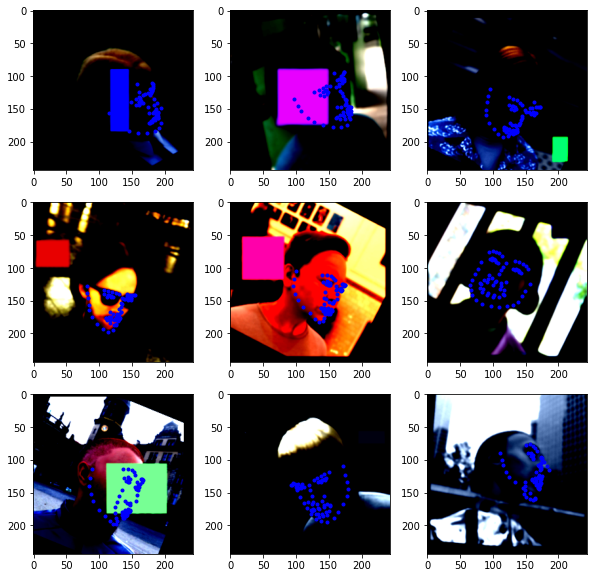

time: 3.48 s (started: 2022-12-09 20:28:38 +00:00)


In [ ]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    #dataset_keypoints_plot(valid_data)
    dataset_keypoints_plot(train_data)


**Model Class**

In [ ]:
from torchvision.models import mobilenet_v3_large,MobileNet_V3_Large_Weights
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
print(model.features)
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large,MobileNet_V3_Large_Weights

class FaceKeypointMobileNetv3(nn.Module):
    def __init__(self, requires_grad):
        super(FaceKeypointMobileNetv3, self).__init__()
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(960, 1280)
        self.hardswish = nn.Hardswish()
        self.dropout = nn.Dropout(p=0.2,inplace=True)
        self.l1 = nn.Linear(1280,140)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.l0(x)
        x = self.hardswish(x)
        x = self.dropout(x)
        x = self.l1(x)
        return x

time: 4.12 ms (started: 2022-12-09 20:28:42 +00:00)


**Training**

In [ ]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark 
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]
    
    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)


time: 2.82 ms (started: 2022-12-09 20:28:42 +00:00)


Training intermediate layer parameters...


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sridhar98. Use `wandb login --relogin` to force relogin


Epoch 1 of 100
Training


282it [06:49,  1.45s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

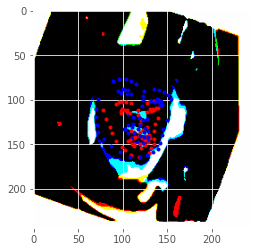

32it [00:36,  1.13s/it]


Train Loss: 20.8705
Val Loss: 14.7065
NME: 1.5980
Epoch 2 of 100
Training


282it [06:34,  1.40s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

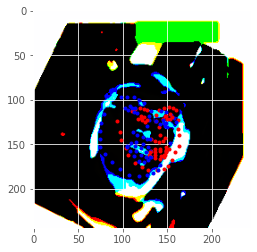

32it [00:35,  1.10s/it]


Train Loss: 10.3901
Val Loss: 10.3225
NME: 1.0979
Epoch 3 of 100
Training


282it [06:35,  1.40s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

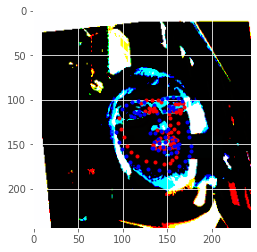

32it [00:35,  1.12s/it]


Train Loss: 8.2451
Val Loss: 7.3712
NME: 0.8696
Epoch 4 of 100
Training


282it [06:36,  1.41s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

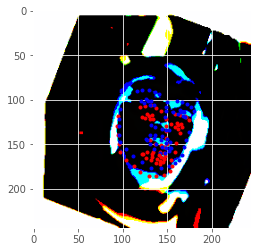

32it [00:34,  1.08s/it]


Train Loss: 7.1264
Val Loss: 8.4664
NME: 0.7050
Epoch 5 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

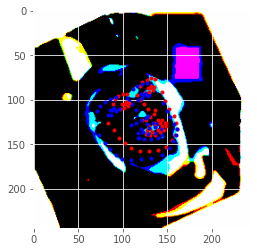

32it [00:36,  1.13s/it]


Train Loss: 6.4415
Val Loss: 9.2292
NME: 1.0970
Epoch 6 of 100
Training


282it [06:28,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

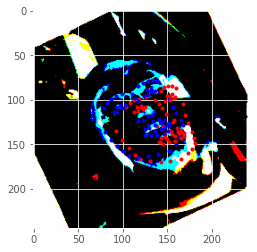

32it [00:36,  1.14s/it]


Train Loss: 5.6893
Val Loss: 7.2227
NME: 0.6009
Epoch 7 of 100
Training


282it [06:29,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

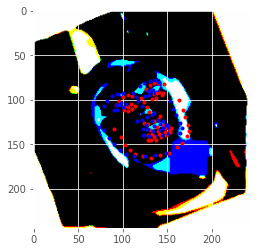

32it [00:34,  1.09s/it]


Train Loss: 5.0483
Val Loss: 4.3428
NME: 0.4922
Epoch 8 of 100
Training


282it [06:29,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

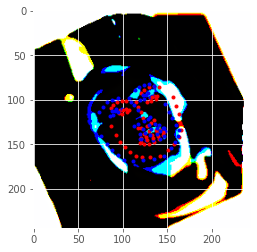

32it [00:34,  1.09s/it]


Train Loss: 4.9611
Val Loss: 5.3348
NME: 0.4322
Epoch 9 of 100
Training


282it [06:28,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

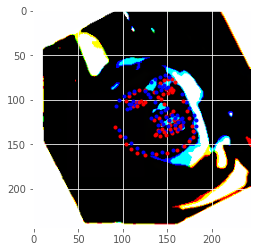

32it [00:35,  1.10s/it]


Train Loss: 4.6902
Val Loss: 5.4677
NME: 0.5681
Epoch 10 of 100
Training


282it [06:26,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

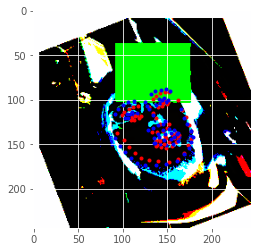

32it [00:34,  1.08s/it]


Train Loss: 4.5180
Val Loss: 4.4088
NME: 0.4543
Epoch 11 of 100
Training


282it [06:27,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

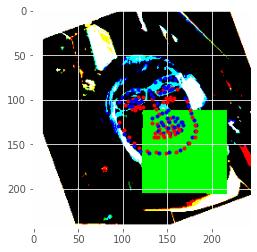

32it [00:35,  1.10s/it]


Train Loss: 4.4207
Val Loss: 3.7476
NME: 0.6576
Epoch 12 of 100
Training


282it [06:30,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

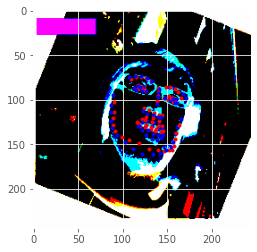

32it [00:35,  1.11s/it]


Train Loss: 4.3018
Val Loss: 3.8004
NME: 0.3328
Epoch 13 of 100
Training


282it [06:28,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

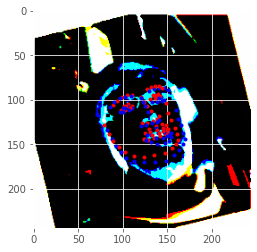

32it [00:34,  1.09s/it]


Train Loss: 4.2408
Val Loss: 5.6752
NME: 0.4577
Epoch 14 of 100
Training


282it [06:27,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

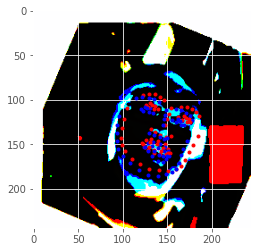

32it [00:34,  1.08s/it]


Train Loss: 4.2525
Val Loss: 4.2685
NME: 0.4534
Epoch 15 of 100
Training


282it [06:27,  1.38s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

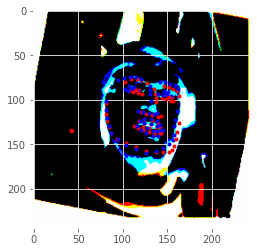

32it [00:34,  1.09s/it]


Train Loss: 4.0341
Val Loss: 3.9122
NME: 0.4325
Epoch 16 of 100
Training


282it [06:25,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

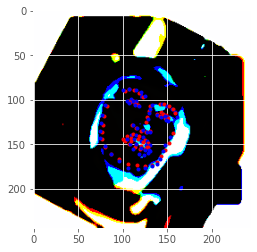

32it [00:34,  1.08s/it]


Train Loss: 4.0498
Val Loss: 3.0174
NME: 0.3507
Epoch 17 of 100
Training


282it [06:23,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

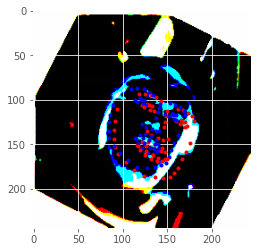

32it [00:35,  1.10s/it]


Train Loss: 4.0328
Val Loss: 6.0552
NME: 0.6319
Epoch 18 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

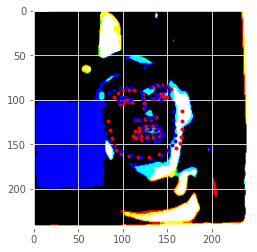

32it [00:34,  1.08s/it]


Train Loss: 3.9139
Val Loss: 3.1477
NME: 0.3838
Epoch 19 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

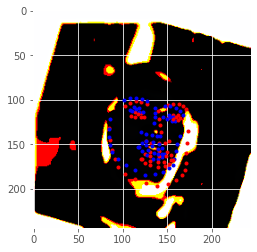

32it [00:34,  1.08s/it]


Train Loss: 3.8468
Val Loss: 5.0935
NME: 0.5522
Epoch 20 of 100
Training


282it [06:25,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

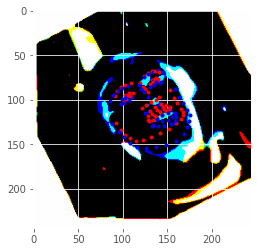

32it [00:34,  1.09s/it]


Train Loss: 3.8699
Val Loss: 4.4392
NME: 0.2809
Epoch 21 of 100
Training


282it [06:25,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

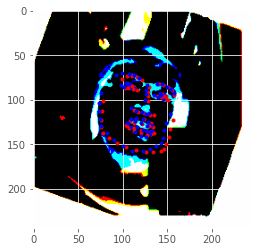

32it [00:34,  1.09s/it]


Train Loss: 3.7501
Val Loss: 2.8372
NME: 0.3746
Epoch 22 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

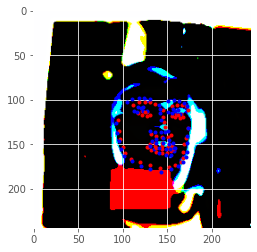

32it [00:34,  1.08s/it]


Train Loss: 3.7384
Val Loss: 2.8057
NME: 0.2690
Epoch 23 of 100
Training


282it [06:24,  1.37s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

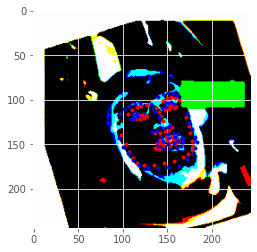

32it [00:34,  1.08s/it]


Train Loss: 3.6734
Val Loss: 2.9154
NME: 0.3866
Epoch 24 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

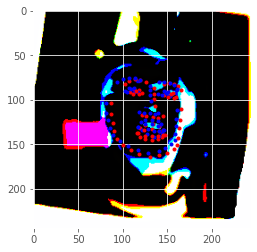

32it [00:34,  1.09s/it]


Train Loss: 3.6149
Val Loss: 3.3352
NME: 0.3457
Epoch 25 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

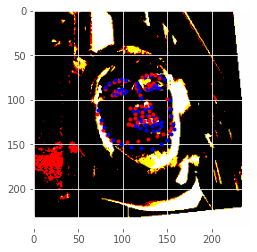

32it [00:34,  1.08s/it]


Train Loss: 3.6076
Val Loss: 3.2693
NME: 0.5937
Epoch 26 of 100
Training


282it [06:24,  1.36s/it]


Validating


  0%|          | 0/31 [00:00<?, ?it/s]

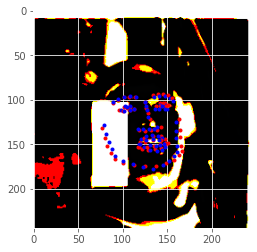

32it [00:34,  1.08s/it]


Train Loss: 3.6018
Val Loss: 2.5085
NME: 0.2459
Epoch 27 of 100
Training


  7%|▋         | 21/281 [00:28<05:47,  1.34s/it]

In [ ]:
matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointMobileNetv3(requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test both MSELoss and SmoothL1Loss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

#load optimizer and model


wandb.init(project="mobilenetv3_1k_testrun")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'content/gdrive/MyDrive/mobilenet/mobilenetv3_10000_a.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('DONE TRAINING')


**Testing Phase**

Training intermediate layer parameters...


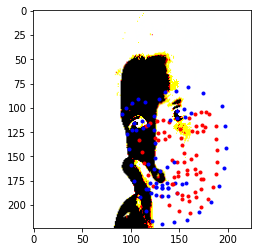

0.389166320745887
0.31666352117343644
1.3120945494169607
1.715235330913708
0.405018179776669
0.6674323588464082
4.712757292057884
12.10299274689544
0.567034169957333
0.2712660211616629
0.49007942688502976
2.7450728526300963
0.23393702956725934
0.48655676040488466
9.651491189941007
1.819845731894579
0.3586829279806433
1.238872077259316
6.343942509244854
5.249601874304788


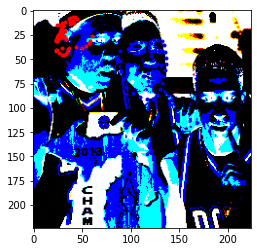

3.212477356484222
2.220756239865137
0.21581070528504614
0.5353971086167623
5.127237362429102
0.30450941081969074
0.41830400769950166
0.34866948072067633
9.42664427655752
3.001339911774789
0.46722639706137264
5.1962302925264
0.309819979675261
2.833543174404589
2.1047583829267387
7.497294462516004
4.581802702533303
5.35348049772109
0.5443789812772126
3.4795218744338974


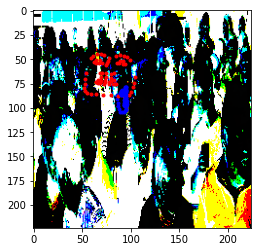

4.930826984179547
4.568029917051232
0.6908014977405407
0.4153331871971069
0.49152077916841186
0.8634175099559042
0.22553404647341896
0.6132025932249625
3.862948305562276
0.3028438173528228
2.5332189336425244
15.087137281341663
1.5951068131944146
0.4104077155868143
0.27768142314808997
0.5662614839684748
15.512246727938319
14.423923235957426
6.66057856814647
0.3919572639808802


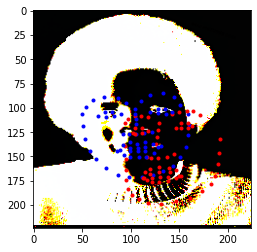

0.4623227260619857
0.826798160787169
0.48270787034958396
1.874879408576438
0.33005867224354946
0.3903003122162194
0.2805266868253184
0.5034988667184978
0.8235447238364343
0.46514125062372863
5.590796650452347
12.045476235027396
0.59450981627141
3.531847041496777
7.735292396531872
0.33286081338773055
0.8923959136508699
1.7444320062151855
4.408087189133945
0.3923646748149887


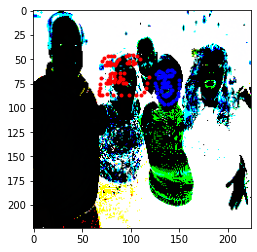

3.3515539443196696
11.332470994341547
0.41900681509105864
7.76494166517028
1.9492078995103734
5.22262064337188
4.355911838972265
7.3073131658504105
0.5319703115732318
4.099150963362469
7.53339805734093
9.12472198548003
0.9281289527394876
0.36820675853902435
2.569859844096924
0.44061232896524205
11.73608546875304
1.367631107336833
0.7857354824156642
0.480469445712922


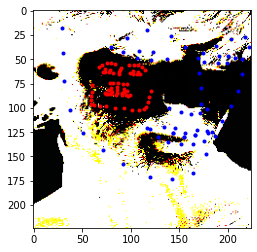

0.6529779186224111
4.240797095490153
0.621098600086176
6.3043958405900495
0.6321157881311891
0.5590246147615723
4.749470029678274
1.9213770933760848
6.405278814088064
5.040580319215972
0.620161706887642
1.388759341990614
0.3639372661477452
0.3670737786114884
0.4194986753464502
1.6486228442340511
5.7446056400847665
0.35366567297530643
10.208848555119392
0.41193949270205826


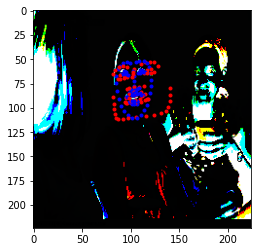

0.3085185382589573
0.2537101254567418
6.504945721068109
0.6774173795573679
2.377294797276027
0.24137828090587227
0.350697575319894
6.062899464676385
1.7145132659332272
0.26167573088689594
1.4929395712651718
3.8820021504993685
2.22431617267836
3.0538929063047546
0.3375339797041915
0.40036378588794425
0.7071573329241629
0.3128641591095628
1.9207980200789467
3.1231720097770093


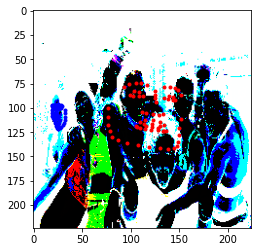

11.28949924315396
6.365146099945325
0.9253641799263758
14.490042908065744
0.5930924735494422
0.36450436143176723
8.777814186224944
1.8187512459456956
0.6718402016885554
0.38900002009759604
0.5146894941460994
8.637409570930089
0.23459398115104751
7.104123076665985
0.3033581652158583
0.4885558811240762
1.390653483187643
0.6424729331007814
3.1490723926183373
0.5204116081401704


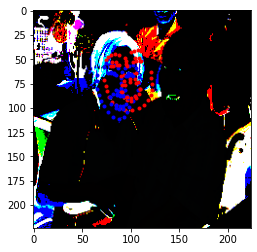

0.5786204248729051
5.202077333878468
0.6867358682150926
0.8698905878513548
1.7571334053232803
11.259255541527576
0.5156367841587687
0.3114080105005931
0.2941039047530679
11.35921903266308
14.584741854467085
0.3456612519142247
0.6254057757169266
0.8881287170059867
1.532671348239478
0.7778545980195759
0.6858987347799549
3.572738183483335
0.4180526453825205
11.765636391221289


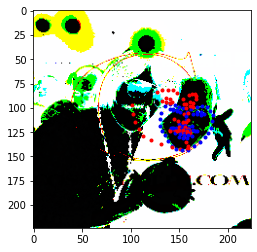

0.33272717067369545
0.8075602474430611
0.4269117382358119
0.4135315531912887
1.8787197801719955
0.31659295095739065
0.2946434208523142
0.5081234983660802
5.031323044793548
0.7897052755511298
0.5468828769840844
1.6144590994792003
0.7253056735567737
0.40599218864362513
0.5395898455104786
3.1571669031939975
0.6961437128144377
0.17130392601969413
0.6233533678222484
2.9302958584373466


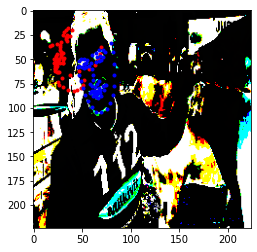

1.5914389212705695
11.608089617759203
0.8146621190352579
0.5249246212656451
1.0063411395515387
0.5551794894520304
0.2814167452791246
5.67994759927743
0.5297426431039601
0.9034421055881168
5.5111917908276284
0.3948109353751309
0.4511546478990444
1.2736444312069901
0.5773686875346256
0.6968867065302607
0.44298079339307395
0.45370869155506255
2.0741962086792496
0.7716283205249962


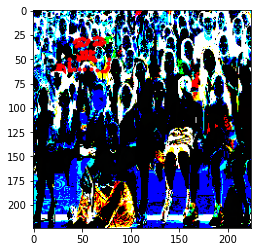

8.56145462040528
0.6379140055064839
0.5489862312316495
3.1457260853845366
0.7755036929748679
0.5817993247859643
9.903963735125396
4.570193107642788
0.4518461963613087
2.2471895148416734
0.28082739783380817
0.5077851413903669
0.21128728539310626
4.604742511012537
1.2882306073095808
0.24851335596320195
0.46763698180745583
17.921461129312537
1.140459280583196
0.45231560296567086


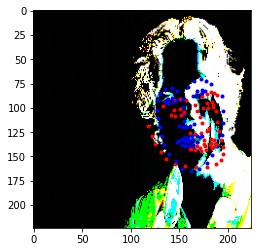

0.3571512648019133
0.30723086255041115
16.328924231319245
0.3820634949926152
0.27274580561689526
1.994133064887691
6.768882558050253
0.36139087466576486
0.5984017012176056
0.5498127920510938
13.237723667124083
2.997563151512013
0.4389858297501574
0.7711547828649207
0.2895040290295982
1.2139114247652911
0.642746264282927
5.705732610123659
0.48801359415399126
0.43260984794900326


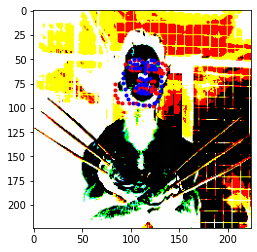

0.22317149372773043
8.350639427206081
0.5557452465782168
0.6463466403595517
5.472178422653306
1.5864651249456285
0.38671348036695347
0.2451087048668104
1.0146836611120231
0.45602396811182017
3.582971153146149
1.6366720332073692
0.4830408546678921
2.661785017450395
0.42985993950843066
12.91112047882871
0.41683288043960853
0.9479719961994718
2.451293265954571
0.28521470921651604


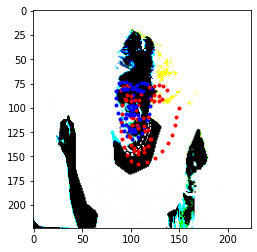

0.8265448509340625
0.5231362319166243
20.273278530170387
0.32902003985936196
4.068896582020523
0.21296901361878537
2.271337248977655
3.185934523163184
5.8769904040750545
5.779530922021924
4.4615020415891395
0.5526247224095037
11.734306858254095
1.035472002679027
0.4886692881383639
4.160428452158911
1.6499321755363066
7.325788256325594
0.24790775657002856
6.4280618021324845


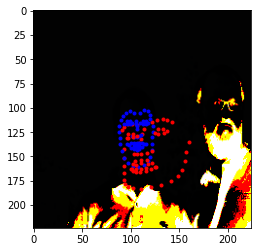

0.8720978599039315
15.971096486220882
1.2765498010434262
3.2374566005036494
12.75269046160146
0.19557453251084142
18.555970404164725
0.34094206356412865
0.6277867273441472
1.270582943707398
0.2863781520354579
0.7062749779539457
15.817041436501368
18.10459095627803
5.457360294494776
3.733404596778019
0.3615707260739964
12.15480653146619
6.026981292023807
0.996804255056479


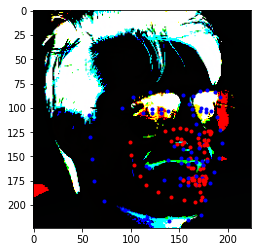

0.43831460772005354
14.037908403073557
2.880685901651152
0.42679933682242804
0.21134604312863048
10.999891272334043
0.27229876731575076
0.6452600224550289
0.3597975704576412
9.292365384971143
1.489423396608889
9.024642644274714
0.3996449642529326
9.143998336156491
5.597106716643037
4.096038725533251
0.6020009753927295
2.2237531398688763
0.5488064028842984
1.1969277327197465


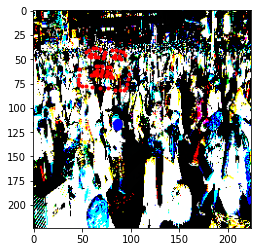

18.18770749236211
1.1705507485232662
9.423858669615013
3.8612842926483397
8.355241270008612
11.387587901243174
0.8881971216133091
6.903672529177089
1.9892251750282364
10.424730125417208
0.33654959190049366
0.1459921645042398
7.739300694470602
0.6852018932113664
7.0693637333760035
0.47755982220351195
0.5134206813336578
2.1875246519947322
0.3645618693737692
17.379655673090877


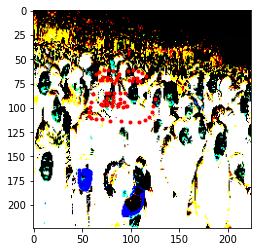

14.33458758257908
6.242411180838301
11.433695764453795
0.520374263018473
2.1105695645575158
12.557865776530484
2.6584040301307237
0.5333346705117397
0.34458667656100117
19.827870188432573
5.823393615230848
4.411381473992376
0.74941136105235
9.312256242142862
3.889088564108724
1.2850871855316954
4.497259358947446
6.186429743454395
4.6784646284546145
3.527090150899442


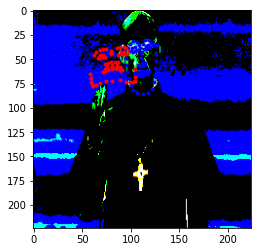

1.568832628218492
0.4914572435818722
0.8365831940898948
0.42525248144548705
3.9235127131026
2.005856985509331
0.7809453123553829
6.424064996245547
9.819409997351068
0.3973991437118164
9.969365473945857
6.013105693910379
2.151136624857497
14.093427033093112
5.6401465737665655
10.222349253401706
4.627298728981992
9.15667350631082
5.633633349705805
6.569825489111942


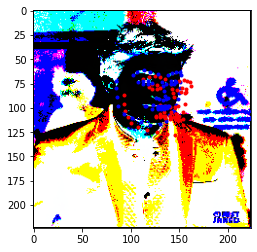

0.3604938509421191
6.989569064698589
0.20489829740610963
3.411428981668382
0.6943052796474776
0.5490858218511315
1.767170021027658
7.35515185305531
0.721411821798022
9.871589882500512
0.8680558789596788
3.4280521470612833
14.899408779004135
1.5779251733798443
0.4253537777109694
7.3735900671262655
2.4116581477015044
0.574442762191385
9.334225585809275
0.6083347296272474


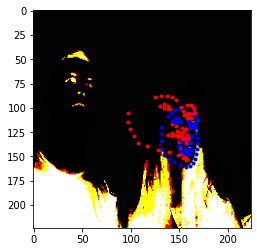

0.5892005951576534
3.2647487705378584
6.080382989609361
4.241968427136367
1.2937059492518832
4.723098792330526
0.43477653889053436
3.5001948658005926
0.5552744212975554
1.4158657051215422
3.0151322739283377
12.301755980897603
4.086734872007133
14.8512617195285
10.796182569324502
0.4582587278563558
1.2164253726989052
9.889922122970923
0.387146030400873
3.796313275116531


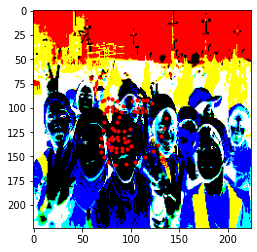

5.239298014201475
9.109716337444448
3.8680399387911035
12.163910305894216
0.42949455891530747
11.029572793620085
11.15968655188857
17.66859992007056
2.9093355629421245
1.196237398837461
0.6567210813638614
0.600719964842071
6.9102252577289836
15.414462045139487
0.4095388785910205
3.6284815756787085
2.248102883580356
3.2088100330405176
0.891095238361419
3.2269937965056665


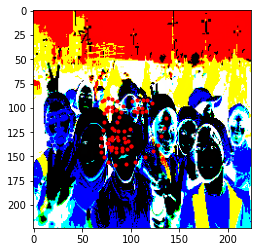

3.814438838898022
5.140677534504106
0.35420179933915413
1.8686334730297207
0.5536551499337907
7.917132470505223
2.726412363509442
0.7282652023504742
0.41679150663226466
11.181507568153284
7.1133841899834875
2.8777082412680532
4.549033386099326
0.6282538361456945
5.209520659591487
2.3661015670670764
0.811463175047831
5.50741329083218
0.20568852243382366
6.169016859600829


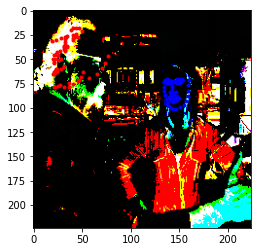

7.466389481588104
4.195394042650861
1.1821796451502289
3.469210254886419
0.28824816341810255
11.946167375646544
3.4283112556683943
0.8870575639798411
0.26027139842854724
0.7047890025400706
0.41660839046974574
0.30581783943042984
0.8315994715363012
0.5298889299220311
3.600818202937749
0.6016469434598455
0.3686821204417067
4.3195744154868425
12.070242368432401
0.6127163957766419


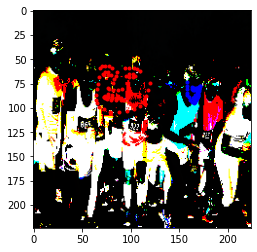

11.368109057319426
9.657267468710304
11.301865772286405
14.920226496852973
3.915895860058887
0.3501089959286683
0.5088655569269931
13.704206601564092
2.282087189344032
1.659764886163922
0.33836205751538845
3.286075460778663
0.4692663327326825
3.658940764249118
13.039270524568197
0.2628959656768572
0.5993362134577879
0.6882705611996586
8.36715080825811
4.572355942670869


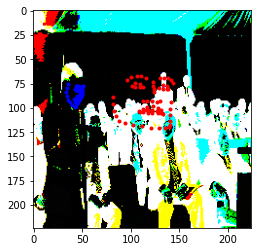

10.748611527041692
4.142929563122867
6.9522236747419335
1.572033436398088
0.28969539444975906
3.0780428218574665
1.5036504628888896
0.5199151914003667
3.312099297189388
3.001170329884152
13.097758930316346
3.988609704074082
11.491626198993998
0.5808618400601581
4.1592970434377685
3.108739203684253
9.55289076848627
10.998056474787523
0.21933895441323342
4.7863742071833535


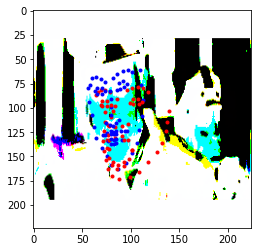

0.5190746154807944
0.9946861001429642
8.71229704209718
1.244836161015514
0.8544204314545696
6.949036292437094
2.9059235906756267
5.656695721035196
5.372836020112957
14.794069508039149
0.5370822804485939
0.32855182000698846
4.048660283796995
4.708024476230259
3.467028876645755
8.402991519565436
0.4358483161107535
3.086059656196584
0.743905191094578
8.948173948829654


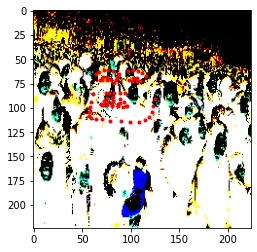

13.593899532528104
7.6389832045912005
7.617636812338234
11.93539292141243
1.283142270420455
0.3112075558699394
1.7673807116013718
0.8750638322252849
0.35947195630021744
3.6855320430614875
0.4775703317784483
10.95195449609664
1.7395932358081359
11.210185038568703
0.4173280911572316
6.35450512209468
3.49757781615065
0.3237091492279811
3.6123358514427215
0.7786373691926646


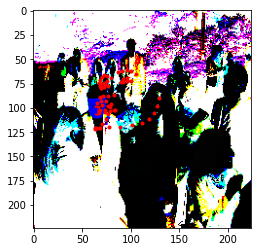

2.6311296289977677
14.264702175772818
5.161921263683795
0.7274133520394006
21.13628488349133
0.4442636666452134
9.445213954404549
0.5115390223799557
0.6463732191640112
4.581724240945009
0.4519775618490798
5.998314102537987
1.0777952674713625
5.3277696125379626
18.088681339838555
3.628234776384033
0.4398437104448149
2.619929765882647
0.47566303636702145
5.7090352515843845
Average NME: 3.708526573876894
time: 9min 42s (started: 2022-12-09 20:29:12 +00:00)


In [ ]:
#Run model on test data from 300WLPA dataset and report NME

model = FaceKeypointMobileNetv3(requires_grad=True).to(DEVICE)
model.eval()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/mobilenet/mobilenetv3_10000_a_to.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300W_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

In [ ]:
model = FaceKeypointMobileNetv3(requires_grad=True).to(DEVICE)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/mobilenet/mobilenetv3_10000_a_to.pt')['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break

Training intermediate layer parameters...
Error while trying to open webcam. Please check again...
time: 425 ms (started: 2022-12-09 20:52:09 +00:00)
